# WeatherPy 
UCB Extension HW6
written by A. Lam

# Analysis
- Observation 1: As evidenced by the Temperature vs. Latitude scatterplot, temperature appears to behave roughly as a function of latitude, with a local maximum at latitude 0 (the equator).
- Observation 2: Cloudiness, Wind Speed and Humidity do not appear to be functions of latitude, as scatterplots of the three do not show any clear relationship  and appear mostly randomly scattered.
- Observation 3: Cloudiness, Wind Speed, and Humidity don't appear to bear any sort of direct relationship to longgitude either.

# Setup

In [1]:
# Modules
# Other modules are imported within the functions in which they are relevant
import pandas as pd
import matplotlib.pyplot as plt
import os
from time import time, strftime, gmtime, sleep

# Generate Coordinates

In [2]:
def rand_coord():
    import random
    # Lat ranges from degrees [-90, 90] (N,S)
    lat = 180*random.random()-90 
    # Long ranges from degrees [-180, 180] (E,W)
    long = 360*random.random()-180
    return [lat,long]

# Convert Coordinates to City, Country

In [3]:
def coord2city(coords):
    # assume coords is a 2 item list of form: [lat,long]
    from citipy import citipy
    # extracts city name
    city = citipy.nearest_city(coords[0],coords[1]).city_name
    # extracts country code
    country = citipy.nearest_city(coords[0],coords[1]).country_code
    out = (city, country)
    return out

# Utility Functions

In [4]:
# Compare intended query aggainst log of failed query calls.
# if current query is already in log, throw disapproval
def check_city_query(city, country_code):
    this_query = pd.DataFrame({
        'City':city,
        'Country Code':country_code,
        'Query String': city + ',' + country_code
    }, index=[0])
    try:
        blacklist = pd.read_csv('failed_queries.csv')
        if this_query['Query String'].isin(blacklist['Query String']).any():
            approved_query = False
        else:
            approved_query = True
    except:
        approved_query = True
    return approved_query

In [5]:
# For new queries that fail to return weather data, write into separate log file
def add_failed_query(city, country_code, lat, lon):
    this_query = pd.DataFrame({
        'City':city,
        'Country Code':country_code,
        'Latitude': lat,
        'Longitude': lon,
        'Query String': city + ',' + country_code
    }, index=[0])
    if os.path.isfile('failed_queries.csv'):
        include_headers = False
    else:
        include_headers = True
    with open('failed_queries.csv','a') as blacklist:
        this_query.to_csv(blacklist, header = include_headers, index = False)

In [6]:
# write to file a timestamped data generation record
def log_generation_performance(date,duration,n_cities,n_iterations,file_name):
    log_entry = pd.DataFrame({
        'Date of Query':date,
        'Time to Generate (s)':duration,
        'Size':n_cities,
        'Iteration Count':n_iterations,
        'File':file_name
    }, index=[0])
    col_order = ['Date of Query','Time to Generate (s)','Size','Iteration Count','File']
    if os.path.isfile('performance_log.csv'):
        include_headers = False
    else:
        include_headers = True
    with open('performance_log.csv','a') as log:
        log_entry[col_order].to_csv(log, header = include_headers, index = False)

# API Call
API call is broken into three functions:
1. Call rand_coord and coord2city to generate an API call and touch endpoint
2. Check for a valid response, if not, run another API call
3. Output valid API call response to dataframe

In [7]:
def rand_city_API(debug = False):
    # Modules
    import requests as req
    import json
    import OpenWeatherMap_API as owm
    
    query_approved = False
    
    while query_approved == False:
        # generate city and log coords, name, and country
        coords = rand_coord()

        # Keep variables for output
        city, country_code = coord2city(coords)
        
        # Check generated query
        query_approved = check_city_query(city, country_code)
    
    city_id_q = '?q=' + city + ',' + country_code
    # API query structure
    base_url = 'http://api.openweathermap.org/data/2.5/weather'
    api_key = '&appid=' + owm.avl
    units = '&units=imperial'
    # construct query URL
    clean_url = base_url+city_id_q+units+'&appid=InsertKey'
    url = base_url+city_id_q+units+api_key
    # make API call
    if debug:
        print('processing URL: ' + clean_url)
    response = req.get(url).json()
    
    #print(json.dumps(response,indent=2,sort_keys=True))
    
    return (response,clean_url,city,country_code,coords[0],coords[1])

In [8]:
# Convert API response to dataframe
def response2df(response, url='not provided'):
    # assume input is a good API call to OpenWeatherMap API
    
    # output variables
    city = response['name']
    country_code = response['sys']['country']
    humidity = response['main']['humidity']
    temperature = response['main']['temp']
    cloudiness = response['clouds']['all']
    windspeed = response['wind']['speed']
    latitude = response['coord']['lat']
    longitude = response['coord']['lon']
        
    # Create dataframe of output variables
    output_order = ['City', 'Country Code', 'Latitude',
        'Longitude', 'Temperature', 'Humidity',
        'Cloudiness', 'Wind Speed', 'URL']
    out = pd.DataFrame({
        'City' : city,
        'Country Code' : country_code,
        'Latitude' : latitude,
        'Longitude' : longitude,
        'Temperature' : temperature,
        'Humidity' : humidity,
        'Cloudiness' : cloudiness,
        'Wind Speed' : windspeed,
        'URL' : url
    }, index = [0])
    
    return out[output_order]

In [9]:
def rand_city_data(debug = False):
    is_valid = False
    while is_valid == False:
        tic = time()
        response, url, city, country_code, lat, lon = rand_city_API(debug = debug)
        if response['cod'] == 200:
            df = response2df(response, url = url)
            is_valid = True
        else:
            # write to failed query log
            add_failed_query(city,country_code,lat,lon)
            is_valid = False
        toc = time()
        # if (toc - tic) < 1: # rate limit is 60 calls per minute => 1 call per second
            # sleep(1 - (toc - tic))
    return df

In [10]:
# Generate Data Set
tic = time() # Track time to generate dataset
print('Data Generation started at: ' + strftime('%d %b %Y %H:%M:%S', gmtime()))
n_cities = 500

data = rand_city_data() # initial df to append to

n_iterations = 1
for i in range(n_cities - 1): # subtract 1 to accomodate for initial df
    data = data.append(rand_city_data(), ignore_index=True)
    # Print status update every 5% complete
    if i % max((len(range(n_cities - 1))+1)//20,1) == 0: # +1 to correct for for loop call
        print('.', end='')
print('\nGenerated ' + str(len((data['City']+data['Country Code']).unique())) + 
      ' unique cities out of ' + str(n_cities) + ' requested.')

# Check if unique cities meets criteria
# if not, drop duplicate rows and replace with new data
while (data['City']+data['Country Code']).nunique() != n_cities:
    n_replace = n_cities - len((data['City']+data['Country Code']).unique())
    for i in range(n_replace): 
        data = data.append(rand_city_data(), ignore_index=True)
        if (i+1) % max(len(range(n_replace))//20,1) == 0: # +1 to correct for 0 index
            print('.', end='')
    n_iterations += 1
    print('\nIteration: ' + str(n_iterations))
    print('Generated ' + str(len((data['City']+data['Country Code']).unique())) + 
          ' unique cities out of ' + str(n_cities) + ' requested.')
    print('Time since start: ' + str(round((time() - tic)/60,2)) + ' min')
    data.drop_duplicates(keep = 'first', inplace = True)

toc = time()

# Print Data Set to .csv
t_stamp = strftime('%d%m%Y%H%M%S', gmtime())
gen_file_name = 'n' + str(n_cities) + 'weather_' + t_stamp + '.csv'
gen_path = os.path.join('gen_data',gen_file_name)
data.to_csv(gen_path, index = False)

# Print dataset generation to log
date = strftime('%d %b %Y %H:%M:%S', gmtime())
log_generation_performance(date, toc-tic, n_cities, n_iterations, gen_path)
print('Data Generation finished at: ' + strftime('%d %b %Y %H:%M:%S', gmtime()))
print('Time to Generate Dataset: ' + str(round((toc-tic)/60,2)) + ' minutes. (' + str(round(toc-tic,2)) + 's)')

Data Generation started at: 13 Dec 2017 23:19:00
....................
Generated 267 unique cities out of 500 requested.
.....................
Iteration: 2
Generated 353 unique cities out of 500 requested.
Time since start: 3.48 min
.....................
Iteration: 3
Generated 402 unique cities out of 500 requested.
Time since start: 4.1 min
........................
Iteration: 4
Generated 429 unique cities out of 500 requested.
Time since start: 4.49 min
.......................
Iteration: 5
Generated 450 unique cities out of 500 requested.
Time since start: 4.78 min
.........................
Iteration: 6
Generated 464 unique cities out of 500 requested.
Time since start: 4.96 min
....................................
Iteration: 7
Generated 472 unique cities out of 500 requested.
Time since start: 5.09 min
............................
Iteration: 8
Generated 483 unique cities out of 500 requested.
Time since start: 5.21 min
.................
Iteration: 9
Generated 486 unique cities out of 

# Plot scatterplot of coordinates for coverage

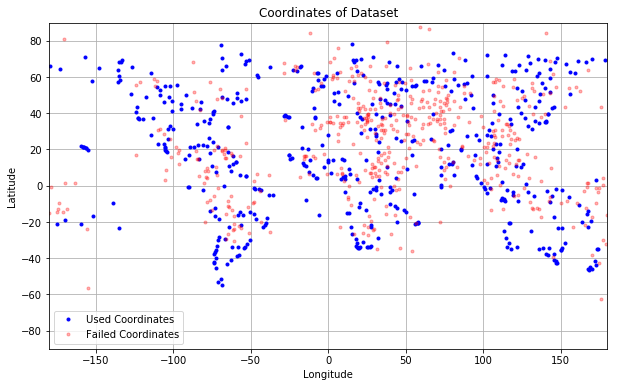

In [11]:
plt.figure(figsize=(10,6))
failures = pd.read_csv('failed_queries.csv')
plt.plot(data['Longitude'],data['Latitude'],'b.',label = 'Used Coordinates')
plt.plot(failures['Longitude'],failures['Latitude'],'r.', alpha = 0.3, label = 'Failed Coordinates')
plt.xlim([-180,180])
plt.ylim([-90,90])
plt.legend(loc = 'best')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Coordinates of Dataset')
plt.grid(True)
plt.show()

# Plot Temperature vs. Latitude

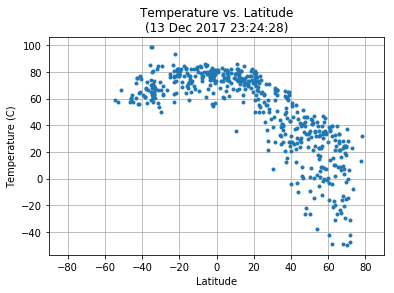

In [12]:
plt.plot(data['Latitude'],data['Temperature'],'.')
plt.xlim([-90,90])
plt.xlabel('Latitude')
plt.ylabel('Temperature (C)')
plt.title('Temperature vs. Latitude\n(' + date + ')')
plt.grid(True)
plt.show()

# Plot Humidity vs. Latitude and Longitude

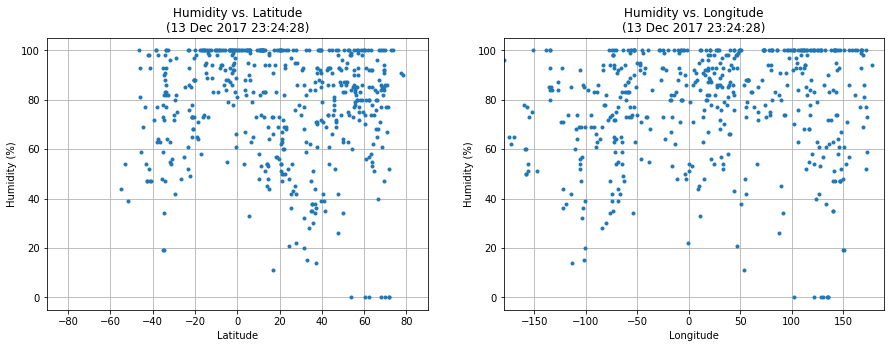

In [13]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(data['Latitude'],data['Humidity'],'.')
plt.xlim([-90,90])
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.title('Humidity vs. Latitude\n(' + date + ')')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(data['Longitude'],data['Humidity'],'.')
plt.xlim([-180,190])
plt.xlabel('Longitude')
plt.ylabel('Humidity (%)')
plt.title('Humidity vs. Longitude\n(' + date + ')')
plt.grid(True)
plt.show()

# Plot Cloudiness vs. Latitude

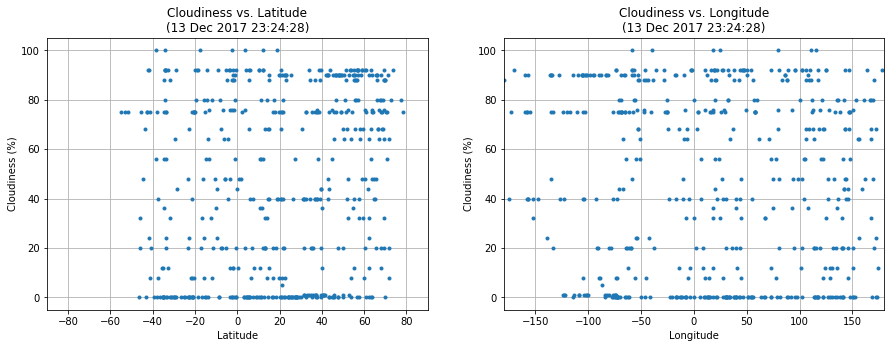

In [14]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(data['Latitude'],data['Cloudiness'],'.')
plt.xlim([-90,90])
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.title('Cloudiness vs. Latitude\n(' + date + ')')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(data['Longitude'],data['Cloudiness'],'.')
plt.xlim([-180,180])
plt.xlabel('Longitude')
plt.ylabel('Cloudiness (%)')
plt.title('Cloudiness vs. Longitude\n(' + date + ')')
plt.grid(True)
plt.show()

# Plot Wind Speed vs. Latitude

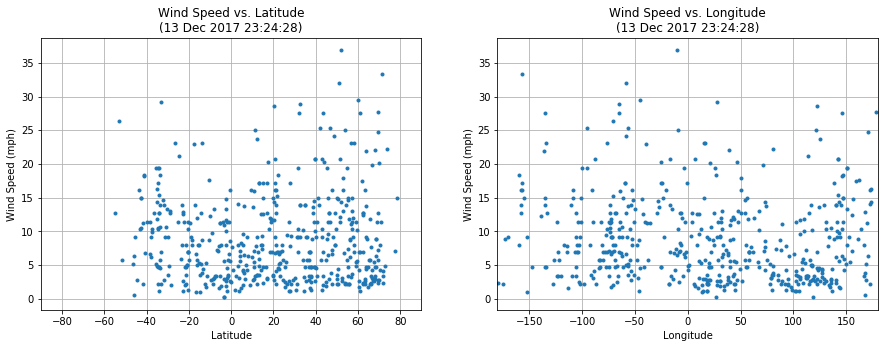

In [15]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(data['Latitude'],data['Wind Speed'],'.')
plt.xlim([-90,90])
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.title('Wind Speed vs. Latitude\n(' + date + ')')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(data['Longitude'],data['Wind Speed'],'.')
plt.xlim([-180,180])
plt.xlabel('Longitude')
plt.ylabel('Wind Speed (mph)')
plt.title('Wind Speed vs. Longitude\n(' + date + ')')
plt.grid(True)
plt.show()